In [83]:
import os
import json
import subprocess
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [84]:
def read_dmat(file):
    h = np.loadtxt(file, max_rows=1, usecols=[0,1], dtype=np.int32)
    A = np.loadtxt(file, skiprows=1, usecols=[0], dtype=np.float32)
    A = np.reshape(A,(h[0],h[1]))
    return A

In [100]:
from dataclasses import dataclass, field

@dataclass
class Config:
    name: str
    solver: str = 'pcg-IC'
    explicit_guess: bool = True
    ccd_guess: bool = True

In [183]:
ROOT = os.getcwd() + '/../'
exe_path = os.path.join(ROOT,'build/bin/convergence_iterative')
scene_path = os.path.join(ROOT,'scenes/3D/')

#scene_name = 'collision_drop_spot_deformed.json'


#scene_name = 'collision_cylinder_beam_deformed.json'
#scene_name = 'collision_cylinder_beam.json'
#scene_name = 'gecko_fall.json'
#scene_name = 'gummy_bear_deformed.json'
scene_name = 'beam_cantilever.json'
scene_name = "collision_press_dragon.json"


In [184]:
# Load in the json file for the current scene
scene_file = os.path.join(scene_path,scene_name)
with open(scene_file, 'r') as f:
    scene_json = json.load(f);

In [185]:
configs = [
    Config('pcg', 'pcg-bj',              explicit_guess=False),
    Config('pcg-explicit', 'pcg-bj',     explicit_guess=True, ccd_guess=False),
    Config('pcg-explicit-ccd', 'pcg-bj', explicit_guess=True),
    Config('pcg-abd', 'pcg-bj-abd',      explicit_guess=False),
    Config('pcr', 'pcr-bj',              explicit_guess=False),
    Config('pcr-explicit', 'pcr-bj',     explicit_guess=True, ccd_guess=False),
    Config('pcr-explicit-ccd', 'pcr-bj', explicit_guess=True),
    Config('pcr-explicit-ccd-abd', 'pcr-bj-abd', explicit_guess=True),
    Config('pcr-abd', 'pcr-bj-abd', explicit_guess=False),
    Config('pcr-explicit-abd', 'pcr-bj-abd', explicit_guess=True, ccd_guess=False)
]

In [186]:
A = []
B = []
tmp_json = 'tmp.json'
timesteps = 1 # number of timesteps to run each trial for
solver_itrs = 500

for (i,config) in enumerate(configs):    
    # Modify scene description
    scene_json['itr_explicit_guess'] = config.explicit_guess
    scene_json['itr_guess_ccd'] = config.ccd_guess
    scene_json['linear_solver'] = config.solver
    scene_json['max_newton_iterations'] = 1
    print('Solver', config.name, ' explicit guess: ', config.explicit_guess, ' ccd guess: ', config.ccd_guess)
    
    # Write current modified json to tmp file
    with open(tmp_json, 'w') as f:
        json.dump(scene_json, f, indent=4)

    # Run simulation
    ret=subprocess.run([exe_path,tmp_json,'-n',str(timesteps), '-m',str(solver_itrs)],
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    # Add data
    data = os.path.join(ROOT,'output/relres.dmat')
    data = read_dmat(data)
    B.append(data)
    data = np.mean(data,axis=1)
    A.append(data)

Solver pcg  explicit guess:  False  ccd guess:  True
Solver pcg-explicit  explicit guess:  True  ccd guess:  False
Solver pcg-explicit-ccd  explicit guess:  True  ccd guess:  True
Solver pcg-abd  explicit guess:  False  ccd guess:  True
Solver pcr  explicit guess:  False  ccd guess:  True
Solver pcr-explicit  explicit guess:  True  ccd guess:  False
Solver pcr-explicit-ccd  explicit guess:  True  ccd guess:  True
Solver pcr-explicit-ccd-abd  explicit guess:  True  ccd guess:  True
Solver pcr-abd  explicit guess:  False  ccd guess:  True
Solver pcr-explicit-abd  explicit guess:  True  ccd guess:  False


In [187]:
print(B[0].shape)

(500, 1)


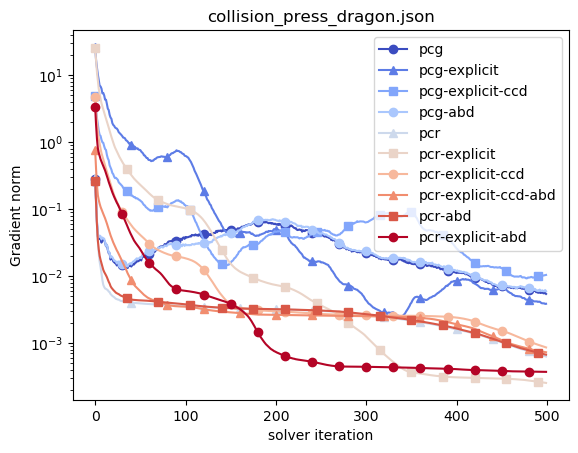

In [188]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(A)))

linestyles =['-']
markers=['o','^','s']
markevery=[30,40,35]


for i in range(len(A)):
    xsize = len(A[i])
    p = plt.plot(np.arange(0,xsize),A[i],color=colors[i],
                 linestyle=linestyles[i%len(linestyles)],
                 marker=markers[i%len(markers)],
                 markevery=markevery[i%len(markevery)])
    p[0].set_label(configs[i].name)
#plt.xscale('log') 

plt.xlabel('solver iteration')
plt.ylabel('Gradient norm')
plt.yscale('log')    
plt.title(scene_name)
plt.legend(loc='upper right')
#plt.savefig('mfem-fem-0.001.eps', format='eps')
plt.show()


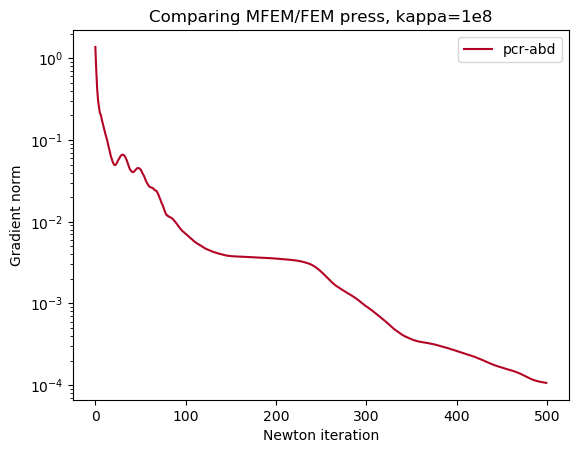

In [99]:
i = 3
xsize = len(A[i])
p = plt.plot(np.arange(0,xsize),A[i],color=colors[i],
             linestyle=linestyles[i%len(linestyles)])#,
p[0].set_label(configs[i].name)

plt.xlabel('Newton iteration')
plt.ylabel('Gradient norm')
plt.yscale('log')    
plt.title('Comparing MFEM/FEM press, kappa=1e8')
plt.legend(loc='upper right')
#plt.savefig('mfem-fem-0.001.eps', format='eps')
plt.show()


In [ ]:
os.remove(tmp_json)